# Time series - multivariate prediction, LSTM network for fixed-sized prediction

In this example we will load prepared data and try to predict it with a simple lstm network producing fixed-sized prediction.

This example is very similar to the feed-forward network except the model is smaller and it can predict from history of arbitrary length.

In [2]:
%tensorflow_version 2.x
%matplotlib inline

import numpy as np
import os
from datetime import date
import re

import matplotlib.pyplot as plt

import pandas as pd
pd.options.display.max_rows = 30
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

def show_loss():
    loss_history = np.array(progress.history['loss'])
    val_loss_history = np.array(progress.history['val_loss'])
                                
    plt.figure(figsize=(20,5))
    plt.ylim(ymin=0, ymax=max(np.max(loss_history), np.max(val_loss_history)))
    plt.plot(loss_history, 'r-')
    plt.plot(val_loss_history, 'g-')
    plt.show()

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


First, **upload data files prepared with the** `weather_data.ipynb` **notebook**

 - `training_set_temp_dp_press.p`
 - `testing_set_temp_dp_press.p`


In [3]:
PATH = '/content/training_set_temp_dp_press.p'
training_df = pd.read_pickle(PATH)

Notice that we would randomly sample the training data from the whole weather history.

The `indices` array will contain starting date for each sample

In [4]:
training_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temp[av],5844.0,-0.001116,0.999123,-2.950767,-0.724290,1.786967e-02,0.883722,2.368041
DPoint[av],5844.0,0.001604,1.000542,-3.524788,-0.708038,3.321240e-02,0.774463,2.256963
SLPress[av],5844.0,-0.004798,1.000654,-4.944317,-0.633782,-1.799073e-02,0.597800,3.184121
Precip[sum],5844.0,0.026801,0.156823,0.000000,0.000000,0.000000e+00,0.000000,2.896000
cos(DoY),5844.0,0.000684,0.707409,-0.999963,-0.708627,4.303538e-03,0.702527,1.000000
sin(DoY),5844.0,0.000012,0.706925,-0.999991,-0.705584,-2.449294e-16,0.705584,0.999991


In [5]:
import random

HISTORY_LEN = 14
PREDICTION_LEN = 7
NUM_SAMPLES = 2000
NUM_INPUTS = 6
NUM_OUTPUTS = 4

indices = random.sample(range(0,len(training_df) - HISTORY_LEN - PREDICTION_LEN), NUM_SAMPLES)

In this example only the output needs to be reshaped into one-dimensional shape. Inputs need to be in a sequence form

In [6]:
ts_data = training_df.values
ts_inputs = np.array([ts_data[i:i + HISTORY_LEN] for i in indices])
ts_outputs = np.array([ts_data[i + HISTORY_LEN: i + HISTORY_LEN + PREDICTION_LEN,:NUM_OUTPUTS] for i in indices]).reshape((NUM_SAMPLES, PREDICTION_LEN * NUM_OUTPUTS))

In [7]:
print(ts_inputs.shape)
print(ts_outputs.shape)

(2000, 14, 6)
(2000, 28)


In [8]:
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, GRU, Input, Dense

inputs = Input(shape=ts_inputs.shape[1:])
x = GRU(32, return_sequences=True, recurrent_activation='sigmoid')(inputs)
x = GRU(16, recurrent_activation='sigmoid')(x)
outputs = Dense(PREDICTION_LEN * NUM_OUTPUTS, activation='linear')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 6)]           0         
                                                                 
 gru (GRU)                   (None, 14, 32)            3840      
                                                                 
 gru_1 (GRU)                 (None, 16)                2400      
                                                                 
 dense (Dense)               (None, 28)                476       
                                                                 
Total params: 6,716
Trainable params: 6,716
Non-trainable params: 0
_________________________________________________________________


In [20]:
def predict(inputs):    
    return model.predict(inputs.values.reshape(1, HISTORY_LEN, NUM_INPUTS), verbose=False).reshape((PREDICTION_LEN, NUM_OUTPUTS))

In [12]:
progress = model.fit(ts_inputs, ts_outputs, validation_split=0.1, epochs=100)

Epoch 1/100
57/57 [==============================] - 0s 6ms/step - loss: 0.2196 - val_loss: 0.2920
Epoch 2/100
57/57 [==============================] - 0s 5ms/step - loss: 0.2171 - val_loss: 0.2971
Epoch 3/100
57/57 [==============================] - 0s 6ms/step - loss: 0.2161 - val_loss: 0.3008
Epoch 4/100
57/57 [==============================] - 0s 6ms/step - loss: 0.2139 - val_loss: 0.2978
Epoch 5/100
57/57 [==============================] - 0s 6ms/step - loss: 0.2151 - val_loss: 0.2891
Epoch 6/100
57/57 [==============================] - 0s 6ms/step - loss: 0.2121 - val_loss: 0.2963
Epoch 7/100
57/57 [==============================] - 0s 6ms/step - loss: 0.2102 - val_loss: 0.2933
Epoch 8/100
57/57 [==============================] - 0s 6ms/step - loss: 0.2088 - val_loss: 0.2920
Epoch 9/100
57/57 [==============================] - 0s 6ms/step - loss: 0.2079 - val_loss: 0.2943
Epoch 10/100
57/57 [==============================] - 0s 5ms/step - loss: 0.2068 - val_loss: 0.2916
Epoch 11/

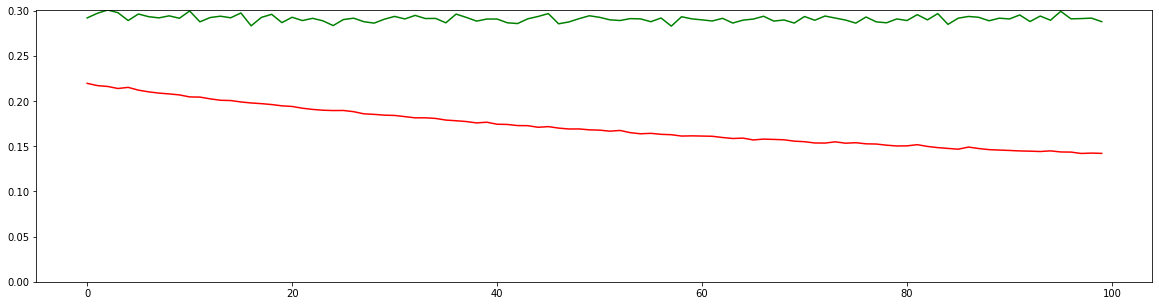

In [13]:
show_loss()

## Prediction phase

To test the prediction, we will take a particular date and feed the history into the network.

Notice the `DatetimeIndex` usage that allows us to easily align our prediction to the input time series.

In [14]:
import datetime
from datetime import timedelta

In [15]:
PATH = '/content/testing_set_temp_dp_press.p'
testing_df = pd.read_pickle(PATH)

In [21]:
def show_prediction(prediction_date):
    
    history = testing_df[prediction_date - timedelta(days=HISTORY_LEN - 1): prediction_date]
    prediction = predict(history)    

    prediction_df = pd.DataFrame(
        prediction, 
        index=pd.date_range(start=prediction_date + timedelta(days=1), freq='D', periods=PREDICTION_LEN)
    )

    ground_true = testing_df[prediction_date - timedelta(days=HISTORY_LEN - 1): prediction_date + timedelta(days=PREDICTION_LEN)]

    plt.figure(figsize = (12, 6))
    plt.bar(ground_true.index, ground_true.iloc[:,3], color='powderblue')
    plt.bar(prediction_df.index, prediction_df.iloc[:,3], color='skyblue')
    plt.twinx()
    gt_plt = plt.plot(ground_true.iloc[:,0:3], linestyle='--')    
    plt.plot(prediction_df.iloc[:,0], color=gt_plt[0].get_color())
    plt.plot(prediction_df.iloc[:,1], color=gt_plt[1].get_color())
    plt.plot(prediction_df.iloc[:,2], color=gt_plt[2].get_color())    
    plt.show()

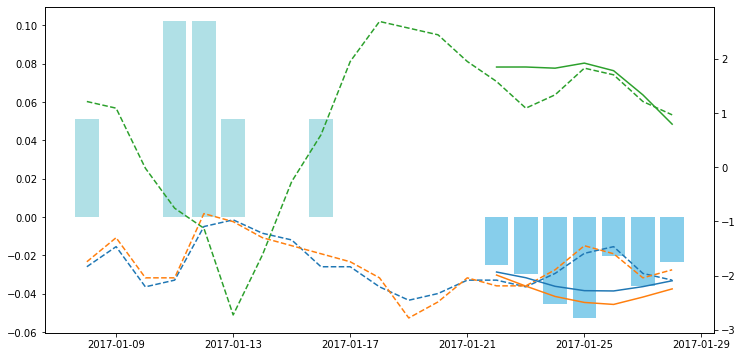

In [22]:
show_prediction(date(2017, 1, 21))

## Evaluation

Let's evaluate against some baseline model (constant forecast)

In [23]:
from tqdm.notebook import tqdm

def evaluate_one(prediction_date):
    
    history = testing_df[prediction_date - timedelta(days=HISTORY_LEN - 1): prediction_date]
    prediction = predict(history)

    ground_truth = testing_df[prediction_date + timedelta(days=1) : prediction_date + timedelta(days=PREDICTION_LEN)].values
    baseline_prediction = np.tile(testing_df.loc[prediction_date:prediction_date], (PREDICTION_LEN, 1))

    return (
        np.sum((prediction[:,:3] - ground_truth[:,:3]) ** 2), 
        np.sum((baseline_prediction[:,:3] - ground_truth[:,:3]) ** 2)
    )

def evaluate_all():
    baseline_error = 0
    model_error = 0

    for i in tqdm(range(2, 52)):
        prediction_date = date(2016,12,31) + timedelta(days=i * PREDICTION_LEN)
        model_e, baseline_e = evaluate_one(prediction_date)
        model_error += model_e
        baseline_error += baseline_e

    return model_error, baseline_error

In [24]:
evaluate_all()

  0%|          | 0/50 [00:00<?, ?it/s]

(546.3666050804725, 696.5734687200606)

## Multiple Outputs

To correctly handle this example, we should be training the network with multiple outputs as prediction of precipitation cannot be below zero.

In [25]:
ts_outputs_1 = np.array([ts_data[i + HISTORY_LEN: i + HISTORY_LEN + PREDICTION_LEN, 0:3] for i in indices]).reshape((NUM_SAMPLES, PREDICTION_LEN * 3))
ts_outputs_2 = np.array([ts_data[i + HISTORY_LEN: i + HISTORY_LEN + PREDICTION_LEN, 3:4] for i in indices]).reshape((NUM_SAMPLES, PREDICTION_LEN))

print(ts_outputs_1.shape)
print(ts_outputs_2.shape)

(2000, 21)
(2000, 7)


In [64]:
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, GRU, Input, Dense

inputs = Input(shape=ts_inputs.shape[1:])
x = GRU(32, return_sequences=True)(inputs)
x = GRU(16)(x)
outputs_1 = Dense(PREDICTION_LEN * 3, activation='linear', name='output_1')(x)
outputs_2 = Dense(PREDICTION_LEN, activation='relu', name='output_2')(x)

model = Model(inputs, [outputs_1, outputs_2])
model.compile(optimizer='adam', loss=['mse', 'mse'], loss_weights=[0.5, 1.0])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 14, 6)]      0           []                               
                                                                                                  
 gru_12 (GRU)                   (None, 14, 32)       3840        ['input_7[0][0]']                
                                                                                                  
 gru_13 (GRU)                   (None, 16)           2400        ['gru_12[0][0]']                 
                                                                                                  
 output_1 (Dense)               (None, 21)           357         ['gru_13[0][0]']                 
                                                                                            

In [55]:
def predict(inputs):    
    p1, p2 = model.predict(inputs.values.reshape(1, HISTORY_LEN, NUM_INPUTS), verbose=False)    
    return np.concatenate((
        p1.reshape((PREDICTION_LEN, 3)),
        p2.reshape((PREDICTION_LEN, 1))
    ), axis=-1)

In [65]:
progress = model.fit(ts_inputs, [ts_outputs_1, ts_outputs_2], validation_split=0.1, epochs=100)

Epoch 1/100
57/57 [==============================] - 4s 18ms/step - loss: 0.4719 - output_1_loss: 0.8853 - output_2_loss: 0.0293 - val_loss: 0.3556 - val_output_1_loss: 0.6567 - val_output_2_loss: 0.0273
Epoch 2/100
57/57 [==============================] - 0s 7ms/step - loss: 0.2915 - output_1_loss: 0.5308 - output_2_loss: 0.0261 - val_loss: 0.2859 - val_output_1_loss: 0.5220 - val_output_2_loss: 0.0249
Epoch 3/100
57/57 [==============================] - 0s 6ms/step - loss: 0.2640 - output_1_loss: 0.4770 - output_2_loss: 0.0255 - val_loss: 0.2758 - val_output_1_loss: 0.5016 - val_output_2_loss: 0.0250
Epoch 4/100
57/57 [==============================] - 0s 6ms/step - loss: 0.2557 - output_1_loss: 0.4606 - output_2_loss: 0.0255 - val_loss: 0.2691 - val_output_1_loss: 0.4888 - val_output_2_loss: 0.0247
Epoch 5/100
57/57 [==============================] - 0s 6ms/step - loss: 0.2498 - output_1_loss: 0.4489 - output_2_loss: 0.0254 - val_loss: 0.2655 - val_output_1_loss: 0.4813 - val_output

In [66]:
def show_multi_loss():
    loss_1 = np.array(progress.history['output_1_loss'])
    val_loss_1 = np.array(progress.history['val_output_1_loss'])

    loss_2 = np.array(progress.history['output_2_loss'])
    val_loss_2 = np.array(progress.history['val_output_2_loss'])
                                
    plt.figure(figsize=(20,5))    
    plt.plot(loss_1, 'r-')
    plt.plot(val_loss_1, 'g-')
    plt.ylabel("output_1")

    ax = plt.gca().twinx()    
    ax.plot(loss_2, 'r--')
    ax.plot(val_loss_2, 'g--')
    ax.set_ylabel("output_2")
    
    plt.show()

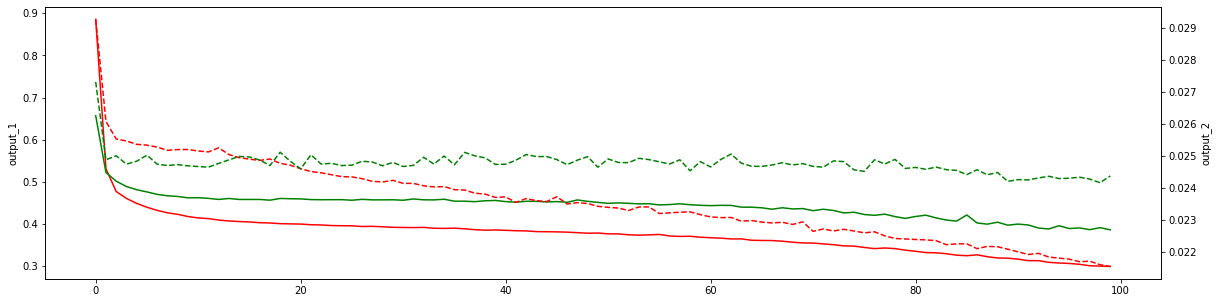

In [67]:
show_multi_loss()

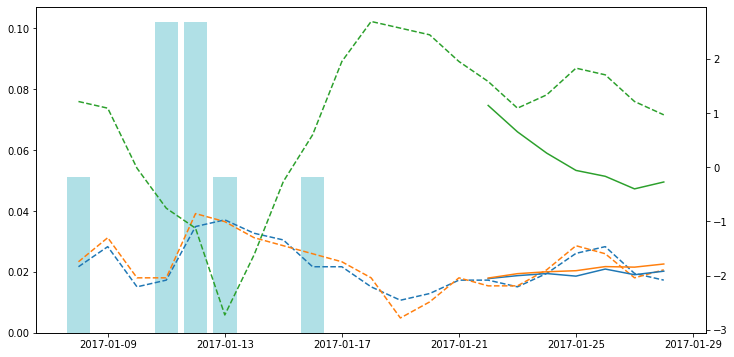

In [68]:
show_prediction(date(2017, 1, 21))

In [69]:
evaluate_all()

  0%|          | 0/50 [00:00<?, ?it/s]

(499.761427873879, 696.5734687200606)

## Encoder-Decoder example

Finally, let's see if we can make a better model for long-term prediction than the previous self-feeded +1 day. We are going to use the seq2seq model usually seen in machine-translation tasks (see https://keras.io/examples/lstm_seq2seq/)

In [86]:
inputs = Input(shape=ts_inputs.shape[1:])
_, states_h, states_c = LSTM(64, return_state=True)(inputs)
encoder_states = [states_h, states_c]

x = LSTM(64, return_sequences=True)(inputs, initial_state=encoder_states)
outputs_1 = Dense(3, activation='linear', name="output_1")(x)
outputs_2 = Dense(1, activation='relu', name="output_2")(x)

model = Model(inputs, [outputs_1, outputs_2])
model.compile(optimizer='adam', loss=['mse', 'mse'], loss_weights=[0.5, 1.0])
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 14, 6)]      0           []                               
                                                                                                  
 lstm_4 (LSTM)                  [(None, 64),         18176       ['input_10[0][0]']               
                                 (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                                  
 lstm_5 (LSTM)                  (None, 14, 64)       18176       ['input_10[0][0]',               
                                                                  'lstm_4[0][1]',           

In [87]:
indices = random.sample(range(0,len(training_df) - 2 * HISTORY_LEN), NUM_SAMPLES)
random.shuffle(indices)

ts_inputs = np.array([ts_data[i:i + HISTORY_LEN] for i in indices])
ts_outputs_1 = np.array([ts_data[i + HISTORY_LEN: i + 2 * HISTORY_LEN, 0:3] for i in indices])
ts_outputs_2 = np.array([ts_data[i + HISTORY_LEN: i + 2 * HISTORY_LEN, 3:4] for i in indices])

print(ts_inputs.shape)
print(ts_outputs_1.shape)
print(ts_outputs_2.shape)

(2000, 14, 6)
(2000, 14, 3)
(2000, 14, 1)


In [93]:
progress = model.fit(ts_inputs, [ts_outputs_1, ts_outputs_2], validation_split=0.1, epochs=100)

Epoch 1/100
57/57 [==============================] - 0s 8ms/step - loss: 0.1498 - output_1_loss: 0.1476 - output_2_loss: 0.0220 - val_loss: 0.3627 - val_output_1_loss: 0.3605 - val_output_2_loss: 0.0224
Epoch 2/100
57/57 [==============================] - 0s 7ms/step - loss: 0.1474 - output_1_loss: 0.1451 - output_2_loss: 0.0220 - val_loss: 0.3618 - val_output_1_loss: 0.3596 - val_output_2_loss: 0.0225
Epoch 3/100
57/57 [==============================] - 0s 8ms/step - loss: 0.1451 - output_1_loss: 0.1429 - output_2_loss: 0.0221 - val_loss: 0.3613 - val_output_1_loss: 0.3591 - val_output_2_loss: 0.0222
Epoch 4/100
57/57 [==============================] - 0s 8ms/step - loss: 0.1436 - output_1_loss: 0.1414 - output_2_loss: 0.0219 - val_loss: 0.3598 - val_output_1_loss: 0.3576 - val_output_2_loss: 0.0224
Epoch 5/100
57/57 [==============================] - 0s 7ms/step - loss: 0.1442 - output_1_loss: 0.1420 - output_2_loss: 0.0220 - val_loss: 0.3636 - val_output_1_loss: 0.3614 - val_output_

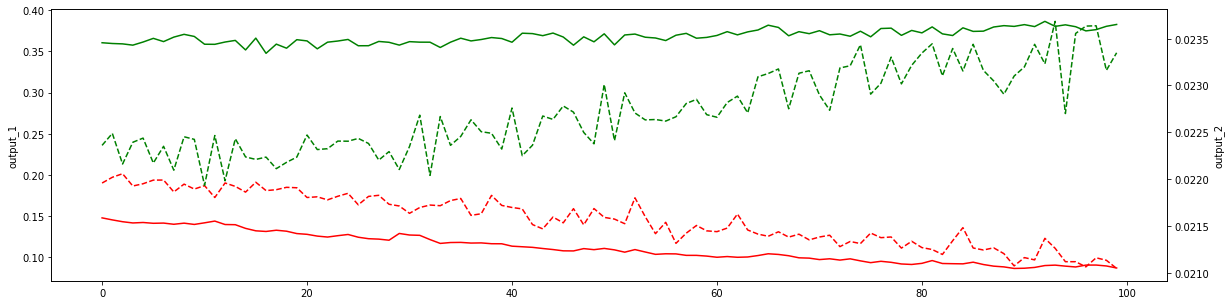

In [94]:
show_multi_loss()

In [95]:
def predict(inputs):    
    p1, p2 = model.predict(inputs.values.reshape(1, HISTORY_LEN, NUM_INPUTS), verbose=False)    
    return np.concatenate((
        p1.reshape((HISTORY_LEN, 3)),
        p2.reshape((HISTORY_LEN, 1))
    ), axis=-1)[:PREDICTION_LEN,:]

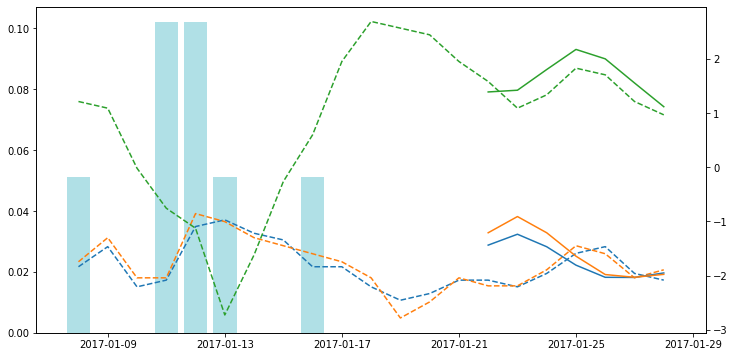

In [96]:
show_prediction(date(2017, 1, 21))

In [97]:
evaluate_all()

  0%|          | 0/50 [00:00<?, ?it/s]

(755.0061804350543, 696.5734687200606)